In [2]:
# imports
import pathlib, pickle
import sqlalchemy as sqa
import numpy as np, matplotlib.pyplot as plt

In [4]:
# read the credentials from the pickle file
db_auth_pkl_file_path = pathlib.Path("/home/neminiz1/flyer_analysis_db_auth.pkl")
with open(db_auth_pkl_file_path, "rb") as fp:
    auth = pickle.load(fp)

# connect to the database with an engine and reflect it onto a metadata object
db_connection_string = (
    f"mssql+pymssql://{auth['username']}:{auth['password']}"
    f"@{auth['ip_address']}:{auth['port']}/{auth['db_name']}?charset=utf8"
)
engine = sqa.create_engine(db_connection_string)  # ,echo=True)
meta = sqa.MetaData()
meta.reflect(bind=engine)

### Find all of the tables in the DB and each table's column names

In [21]:
for table in meta.tables:
    print(f"-------{table} table----------")
    table_pks = [
        key.name for key in sqa.inspection.inspect(meta.tables[table]).primary_key
    ]
    for column in meta.tables[table].columns:
        prepend = "PRIMARY KEY: " if column.name in table_pks else ""
        foreign_keys = [
            f"FK: {key.target_fullname}"
            for key in meta.tables[table].columns[column.name].foreign_keys
        ]
        append = f" ({','.join(foreign_keys)})" if len(foreign_keys) > 0 else ""
        print(f"\t{prepend}{column}{append}")

-------epoxy table----------
	epoxy.epoxy_id
	PRIMARY KEY: epoxy.epoxy_name
	epoxy.description
	epoxy.epoxy_supplier
	epoxy.recordid
-------experiment table----------
	experiment.performed_by
	experiment.date
	experiment.energy
	experiment.theoretical_beam_diameter
	experiment.fluence
	experiment.beam_shaper_input_beam_diameter
	experiment.beam_shaper
	experiment.effective_focal_length
	experiment.drive_laser_mode
	experiment.oscillator_setting
	experiment.amplifier_setting
	experiment.attenuator_angle
	experiment.new_energy_measurement
	experiment.booster_amp_setting
	experiment.preamp_output_power
	experiment.pdv_spot_size
	experiment.focusing_lens_arrangement
	experiment.system_configuration
	experiment.current_set_point
	experiment.oscilloscope_range
	experiment.pdv_method
	experiment.seed_laser_wavelength
	experiment.reference_laser_wavelength
	experiment.time_per_div
	experiment.carrier_freq
	experiment.camera_lens
	experiment.doubler
	experiment.camera_aperture
	experiment.lens_

### Plotting the dates of every experiment

In [40]:
with engine.connect() as conn:
    min_date = conn.execute(sqa.text("SELECT MIN(date) FROM experiment")).first()[0]

with engine.connect() as conn:
    max_date = conn.execute(sqa.text("SELECT MAX(date) FROM experiment")).first()[0]

with engine.connect() as conn:
    results = conn.execute(sqa.text("SELECT date, performed_by FROM experiment")).all()

In [41]:
experiment_dates_for_performer = {}
for res in results:
    if res.performed_by not in experiment_dates_for_performer:
        experiment_dates_for_performer[res.performed_by] = []
    experiment_dates_for_performer[res.performed_by].append(res.date)

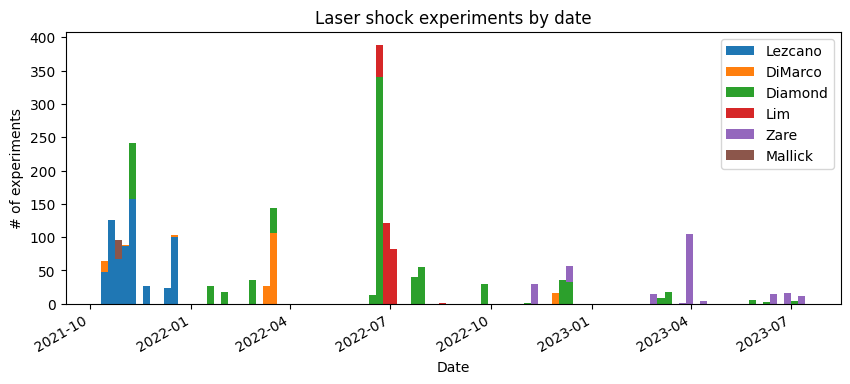

In [57]:
f, ax = plt.subplots(figsize=(10.0, 4.0))
ax.hist(
    experiment_dates_for_performer.values(),
    bins=100,
    range=(min_date, max_date),
    label=list(experiment_dates_for_performer.keys()),
    stacked=True,
)
ax.legend(loc="best")
ax.set_xlabel("Date")
ax.set_ylabel("# of experiments")
ax.set_title("Laser shock experiments by date")
f.autofmt_xdate()
plt.show()

### Getting the numbers of experiments satisfying certain criteria and their dates

### Finding the experiments that have video analysis data